In [2]:
import numpy as np
from cleaning import clean_data, SMOTE_resample
from evaluate import qwk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.metrics import classification_report, cohen_kappa_score
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

In [6]:
# Load Data
X_train, y_train, X_test, y_test = clean_data('')

# SMOTE Resample
X_train, y_train, X_test, y_test = SMOTE_resample(X_train, y_train, X_test, y_test)

print(f'Training = {X_train.shape}')
print(f'Testing = {X_test.shape}')

Training = (14689, 335)
Testing = (6296, 335)


In [4]:
# KNN Classifier
nn = [5, 10, 25, 50]
weights = ['uniform', 'distance']
leaf_sizes = [15, 30, 45]
ps = [1, 2, 3, 4, 5]

random_grid = {
    "n_neighbors": nn,
    "weights": weights,
    "leaf_size": leaf_sizes,
    "p": ps,
}

knn = KNeighborsClassifier()
knn_random = RandomizedSearchCV(estimator=knn, param_distributions=random_grid, n_iter=25, cv=3, verbose=0, n_jobs=-1, error_score=np.NINF)
knn_random.fit(X_train, y_train)
print(f'Best Parameters = {knn_random.best_params_}')
print(f'Best Score = {knn_random.best_score_}')

Best Parameters = {'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'leaf_size': 30}
Best Score = 0.5082030236821886


In [5]:
# Best parameters
# best_params = {'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'leaf_size': 30}
best_params = knn_random.best_params_
knn = KNeighborsClassifier(weights=best_params['weights'], p=best_params['p'], n_neighbors=best_params['n_neighbors'], leaf_size=best_params['leaf_size'])
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f'Train Score = {knn.score(X_train, y_train)}')
print(f'Test Score = {knn.score(X_test, y_test)}')
print(f'QWK = {qwk(y_test, y_pred)}')
print(f'Cohens Kappa Score = {cohen_kappa_score(y_test, y_pred)}')


Train Score = 0.9928517938593505
Test Score = 0.5336721728081322
QWK = 0.9999999900715117
Cohens Kappa Score = 0.41707783026461553


In [12]:
# PCA Decomposition
pca = PCA(n_components=50, svd_solver='auto')
pcaX_train = pca.fit_transform(X_train)
pcaX_test = pca.transform(X_test)

# Select K Best
kb = SelectKBest()
kbX_train = kb.fit_transform(X_train, y_train)
kbX_test = kb.transform(X_test)

# Variance Threshold
vt = VarianceThreshold(threshold=(.8 * (1 - .8)))
vtX_train = vt.fit_transform(X_train, y_train)
vtX_test = vt.transform(X_test)

c:\Users\Noah\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 38  69  94 121 129 139 170 183 211 253 259 262 273] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Noah\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


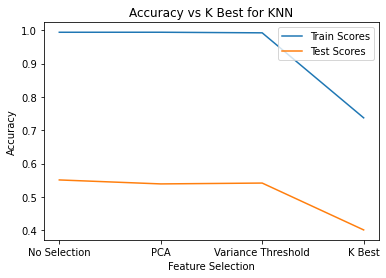

In [15]:
# Feature Selection
dataLabels = ['No Selection', 'PCA', 'Variance Threshold', 'K Best']
data = [(X_train, X_test), (pcaX_train, pcaX_test), (vtX_train, vtX_test), (kbX_train, kbX_test)]

trainScores = []
testScores = []
for i, label in enumerate(dataLabels):
    xtrain, xtest = data[i]
    knn = KNeighborsClassifier(weights=best_params['weights'], p=best_params['p'], n_neighbors=best_params['n_neighbors'], leaf_size=best_params['leaf_size'])
    knn.fit(xtrain, y_train)
    trainScores.append(knn.score(xtrain, y_train))
    testScores.append(knn.score(xtest, y_test))

plt.plot(dataLabels, trainScores, label='Train Scores')
plt.plot(dataLabels, testScores, label='Test Scores')
plt.title(f'Accuracy vs Feature Selection Methods for KNN')
plt.xlabel('Feature Selection')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()